# Introduction

The paper that was attempted to be reproduced is *Learning Where to Focus for Efficient Video Object Detection*. This paper proposes multiple new modules in the field of video object detection. The first one, Learnable Spatio-Temporal Sampling (LSTS) is meant to allow more accurate propagation and alignment of high-level features across frames. The other two, Sparsely Recursive Feature Updating (SRFU) and Dense Feature Aggregation (DFA), are meant to improve the dense low-level features and improve the feature representation. The authors proposed these modules because previous efforts on using temporal information in videos relied either on temporal information for post-processing to make the object detection results more coherent or on propagating features to avoid dense feature extraction. However, optical flow based operations are always needed leading to multiple disadvantages. The first is the fact that optical flow significantly increases the number of model parameters, the second is that optical flow is not able to accurately represent the correspondences among high-level features. The final disadvantage is that optical flow is very time-consuming which will hinder practical applications. The three modules proposed in this paper are meant to address these three main disadvantages of the current methods.

# Method from the paper
The method that was used in the paper consists of multiple steps, these steps will be explained below.

**Framework overview**

The frames are first divided into keyframes and non-keyframes. For the keyframes a memory is kept and more accurate feature extraction methods (SRFU) are used than for non-keyframes (DFA). This was only done for certain frames to reduce the computational cost. In the paper every tenth frame was considered to be a keyframe.

**LSTS**

The LSTS module consists of four main steps. These steps are:

1. Sampling some locations on the feature.
2. Calculating the correspondence similarity weights of the sampled locations on the current and the next frame.
3. Aggregating the feature and the weights to get a propagated feature.
4. Iteratively updating the sampled locations to minimise a loss function.

A schematic of these steps is shown in the picture below:

![picture](https://drive.google.com/uc?export=view&id=1sIHdQsIbW2ByM65gwX__11fzFREu9Fh6)

**SRFU**

The SRFU module maintains and updates the temporal feature $F^{memory}$ over the entire video. The procedure is graphically shown below:

![picture](https://drive.google.com/uc?export=view&id=11vHqK_z9oxYtt0VuweAjCeLFolahytmU)

As can be seen in the figure, the LSTS module is used to counteract misalignment between frames by predicting the motion of the features leading to $F_{t^{1}}^{align}$. An aggregation unit is then used to generate the updated feature $F_{t^{1}}^{memory}$. Then the concatenation of $F_{t^{1}}^{align}$ and $F_{t^{1}}^{memory}$ are fed into several convolutional layers with a softmax operation to produce corresponding weights. Finally the memory feature of the keyframe can be updated using the following equation where $\odot$ is the Hadamard product:

$F_{t^{1}}^{memory} = W_{t^{1}} \odot F_{t^{1}} + W_{t^{1}}^{align} \odot F_{t^{1}}^{align}$

**DFA**

The DFA module is used for the non-keyframes. It reuses the high-level features of the keyframes to improve the quality of the features of the non-keyframes. The structure is shown below:

![picture](https://drive.google.com/uc?export=view&id=1wwTTnGxE_2SrIICyLZGa_ZrDsrBfI9Ql)

First, the non-keyfrmae feature $F_{t^{1}+k}^{low}$ is transformed into $F_{t^{1}+k}^{high}$, which is a prediction of the semantic-level feature, using significantly less computations. After that, LSTS is once again applied to counteract the misalignment between frames and an aggregation unit is used to predict the aggregation weights. Finally, the task feature $F_{t^{1}+k}^{task}$, which contains more semantic-level information than $F_{t^{1}+k}^{low}$ and allows for better detection results, is computed as follows:

$F_{t^{1}+k}^{task} = W_{t^{1}+k}^{align} \odot F_{t^{1}+k}^{align} + W_{t^{1}+k}^{high} \odot F_{t^{1}+k}^{high}$


# How was it implemented?
For the implementation, only the LSTS was implemented. This was done due to a lack of time and a too large complexity for the other two models. The implementation went as follows:

 First, a decision on the dataset was made. This was done due to the incredible size of the ILSVRC2015 dataset (~6GB vs. ~130GB). The effect of this cannot be obtained from the results, although it is assumed that this decision already has a large impact on the results. Not only because there is far less data, but also because there different data. Nevertheless, it should be possible to obtain similar results as long as the method is the same. Hence, the choice in dataset shouldn't matter too much. Additionally, due to computation time, only the first 11 video's from the archery class were chosen for training. It is clear that the amount of training data is really small and definitely has a significant effect on the final results.\
Second, the feature extraction model was obtained. For thism the FCN-ResNet101 model is used {https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_fcn_resnet101.ipynb#scrollTo=hkwKC3eQWh8D}.


In [ ]:
#Connect Colab to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
#for fcn model:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import random as rd

Functions for loading a video from a google drive

In [ ]:
#Functions obtained from: https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/action_recognition_with_tf_hub.ipynb#scrollTo=mOHMWsFnITdi

def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):


  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'fcn_resnet101', pretrained=True)
model.eval()

In [ ]:
#Make function of code from source
def fcn_resnet_101(frame):
  # Download an example image from the pytorch website
  import urllib
  url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
  try: urllib.URLopener().retrieve(url, filename)
  except: urllib.request.urlretrieve(url, filename)
  input_arr = frame*255
  input_image = Image.fromarray(input_arr.astype('uint8'), 'RGB')
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input_tensor = preprocess(input_image)#.type('torch.DoubleTensor') 

  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)
  return output_predictions

 This model is able to extract features from an input image, which can then be used in later steps. Unfortunately, this is not the same feature extraction model used in the paper (The paper uses the R-FCN feature extraction model) and will therefore also have an impact of the final results. The decision to use the FCN-ResNet101 over the R-FCN feature extraction model was made due to the fact that it was not possible to implement the R-FCN model.\
Third, the learning rate and the number of epochs was set. These were set to $2.5\cdot10^{-8}$ and 6 respectively. In the paper, these were set to $2.5\cdot10^{-4}$ and 4. The value for the learning rate was found to be too large and was therefore scaled down significantly, and the number of epochs was increased to compensate for the amount of data. 
After setting the learning rate and the number of epochs, the following set of steps were taken in sequence for each frame.
1. Convert the frame of the video to the feature mapping. This is shown in the figures below:



from:                                                
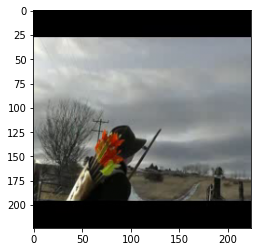 

to:

 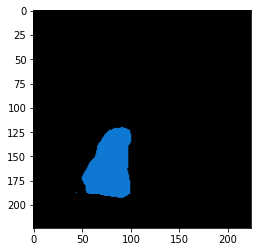
 

2. Select a point on the feature map around one wishes to sample around. This is point $p_0$. For this, the centre pixel was chosen (pixel [112,112] after cropping image to [224,224] pixels). This point was kept constant throughout the training.


3. Take a sample around the location of the chosen point from the previous frame. This yields a set of sampled points $p_n$. It was decided to take 9 samples for each frame, although one could choose to take more samples. Initially, a Gaussian distribution is chosen, with a mean of 0 and a standard deviation of 10. During the implementation, a seed of 0 is chosen to keep the initialisation consistent over each run, although the seed can be chosen arbitrarily.


In [ ]:
def take_sample(mean,std):
  return int(rd.gauss(mean,std))

4. The similarity is computed for each sampled point w.r.t. the specific chosen point in step 1. For this, the same method is used as in the paper: First, $f(F_t)_{p_n}$ is computed using equation 1 from the paper: $f(F_t)_{p_n} = \sum_{q}G(p_n,q)\cdot f(F_t)_q$ . This is repeated for each sampled location $p_n$ and yields a single number per $p_n$. Then, the similarity between the feature in location $p_n$ of the previous frame and the feature in $p_0$ of the current frame is computed by computing the difference between the two values. This is different from the method in the paper, as they compute the similarity by using the dot product between two vectors. However, since the features in this case are only a singular number, it wouldn't make sense to multiply them with each other, to compute the similarity (if the feature is 0 and the sample feature is 255, the similarity would be exactly the same (equal to 0) as when the sample feature is 50 even it 50 is much more similar) and hence the difference between the two values is taken as a measure of the similarity. After obtaining the similarity, the weights are normalised by dividing them over the sum of all the weights as according to equation 3 from the paper: $S(p_n) = \frac{s(_{p_n})}{\sum_{n=1}^{N}s(_{p_n})}$.


In [ ]:
def eq_1_of_paper(arr,pnx,pny):
  summation = 0
  for y in range(len(arr)):
    for x in range(len(arr[0])):
      q_x = x + 1 #because 0-base index
      q_y = y + 1 #because 0-base index
      F_ft_q = arr[y][x][0]
      summation += max(0,(1-abs(q_x-int(pnx))))*max(0,(1-abs(q_y-int(pny))))*F_ft_q
  return summation

5. After obtaining the similarity weights, the sampled locations can be updated.  This is done bycomputing the derivative of the similarity weights w.r.t.  the sample locations.  Since one can compute a derivative of the interpolation kernel G(.,.)  w.r.t. pn, it is possible to also obtaina derivative for the similarity weights w.r.t.pn.  The derivatives were obtained as follows: $s(p_n) = \sum_{q}G(p_n,q)\cdot f(F_t)_{p_n} - g(F_{t+k})_{p_0}$ $G(p_n,q)  = g(p_{n_x},q_x) \cdot g(p_{n_y},q_y) = max(0,1-||p_{n_x} - q_x||) \cdot max(0,1-||p_{n_y} - q_y|$ $\frac{\partial G}{\partial p_n} = \frac{\partial G}{\partial p_{n_x}} + \frac{\partial G}{\partial p_{n_y}} = max(0,-p_{n_x})\cdot max(0,1-||p_{n_y} - q_y||) + max(0,-p_{n_y})\cdot max(0,1-||p_{n_x} - q_x||)$


In [ ]:
def derivatives(prev_frame,x_loc,y_loc):
  #Compute derivative in x
  x_der = 0
  y_der = 0
  for y in range(len(prev_frame)):
    for x in range(len(prev_frame[0])):
      condition_x = int(x_loc) - (x+1)
      condition_y = int(y_loc) - (y+1)
      if condition_x < 1:
        x_der += -max(0,(1-condition_y))*prev_frame[y][x][0]
      if condition_y < 1:
        y_der += -max(0,(1-condition_x))*prev_frame[y][x][0]
  return x_der,y_der

6.  After obtaining the derivatives, the sampled locations are updated in the direction of the negative derivative multiplied by the learning rate (equal to $2.5\cdot10^{-8}$). This is due to the fact that the difference between the two feature values should be minimised.


7. With the updated positions, the steps 1-6 are repeated for the following frame. The updated sample locations are then fed back into step 3. 

In [ ]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

distribution_file = "distributions.txt"

N_samples = 9
rd.seed(0)
std = 10
lr = 2.5*10**(-8)
epochs = 9

distribution_x = 224*[0]
distribution_y = 224*[0] 

import os
directory = '/content/drive/MyDrive/UCF-101/Archery/'

#with open("/content/drive/MyDrive/distributions.txt","w") as textfile:
for epoch in range(epochs):
  print(f"epoch: {epoch}")
  video = 0
  for filename in os.listdir(directory):
      print(f"video: {video}")
      if video <= 10:
          if filename.endswith(".avi"):
              vid = load_video(directory + filename)
              n_frame = 0
              for f in range(len(vid)):
                frame = vid[f]
                output_predictions = fcn_resnet_101(frame)
                # plot the semantic segmentation predictions of 21 classes in each color
                r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(Image.fromarray(frame.astype('uint8'), 'RGB').size)
                r.putpalette(colors)
                F_frame = image.img_to_array(r)
                #plt.imshow(r)
                #plt.show()
                if f == 0: 
                  F_prev_frame = F_frame
                  pass
                else: 
                  x_loc,y_loc = 112,112
                  F_tk_po = np.zeros((N_samples))
                  for index in range(N_samples):
                    F_tk_po[index] = F_frame[y_loc][x_loc][0]
                  if n_frame == 0 and video == 0 and epoch == 0:
                    #sample 
                    sample_x,sample_y = [take_sample(x_loc,std) for i in range(N_samples)],[take_sample(y_loc,std) for j in range(N_samples)]                  
                    print(sample_x,sample_y)
                  #Sample location on current frame
                  F_Ft_pn = np.zeros((N_samples))
                  for index in range(len(sample_x)):
                    F_Ft_pn[index] = eq_1_of_paper(F_prev_frame,int(sample_x[index]),int(sample_y[index]))
                  s_pn = abs(np.subtract(F_Ft_pn,F_tk_po)) #differnce between two vectors 
                  if sum(s_pn) ==0:
                    n_frame += 1
                  else:
                    S_pn = s_pn/np.sum(s_pn)
                    #Obtain derivatives for updating:
                    for index in range(N_samples):
                      x_der,y_der = derivatives(F_prev_frame,sample_x[index],sample_y[index])
                      #Update sample location. Only go into direction of negative dervative
                      if x_der <0:
                        sample_x[index] += x_der*lr 
                      elif x_der >0:
                        sample_x[index] -= x_der*lr 
                      if y_der <0:
                        sample_y[index] += y_der*lr 
                      elif y_der >0:
                        sample_y[index] -= y_der*lr 
                      #State limits of image
                      if sample_x[index] > 224:
                        sample_x[index] = 224
                      if sample_x[index] < 0:
                        sample_x[index] = 0
                      if sample_y[index] < 0:
                        sample_y[index] = 0
                      if sample_y[index] > 224:
                        sample_y[index] = 224  
                    F_prev_frame = F_frame
                    n_frame += 1
                  for index in range(N_samples):
                    distribution_x[int(sample_x[index])-1] += 1
                    distribution_y[int(sample_y[index])-1] += 1
                  print(f"frame: {n_frame}")
              indexes = [num for num in range(1,225)]
          textfile = open("/content/drive/MyDrive/distributions.txt","w")
          textfile.write(f"epoch {epoch}\n")
          textfile.write(f"video {video}\n")
          textfile.write(f"distribution x: {distribution_x}\n")
          textfile.write(f"distribution y: {distribution_y}\n")
          textfile.write(f"sample x: {sample_x}\n")
          textfile.write(f"sample y: {sample_y}\n")
          textfile.close()
          video += 1
  plt.plot(indexes,distribution_x)
  plt.show()
  

# Results
The resulting distribution of the sampled locations are: 

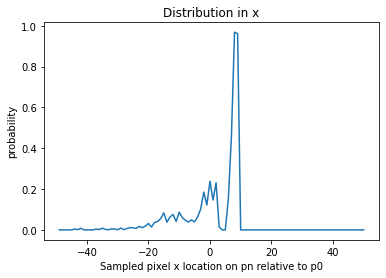

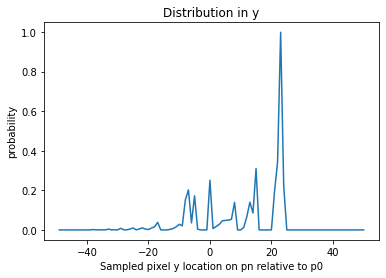

In [ ]:
import matplotlib.pyplot as plt
#Plot distribution
#distribution lists are taken from produced txt file in the training loop
x_dist = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 105, 6, 5, 6, 6, 11, 7, 6, 9, 232, 8, 10, 11, 10, 9, 10, 11, 10, 9, 462, 10, 7, 9, 13, 8, 12, 235, 83, 465, 11, 10, 15, 10, 238, 87, 468, 135, 36, 270, 233, 60, 507, 60, 354, 630, 534, 373, 884, 561, 932, 1539, 682, 1721, 1881, 2418, 3411, 1418, 2264, 2558, 1284, 2601, 1646, 1225, 942, 1153, 874, 1370, 2067, 3349, 1794, 3081, 1442, 1941, 90, 0, 0, 981, 2494, 2803, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#normalise to get distribution:
for index in range(len(x_dist)):
  x_dist[index] = (x_dist[index])/sum(x_dist)


  
#obtain indexes
indexes = [number-112 for number in range(1,225)]
#plot
plt.plot(indexes[62:162],x_dist[62:162])
plt.xlabel("Sampled pixel x location on pn relative to p0")
plt.ylabel("probability")
plt.title("Distribution in x")
plt.show()

#Plot distribution
y_dist = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 9, 9, 15, 11, 242, 27, 26, 26, 477, 14, 22, 250, 558, 23, 258, 567, 222, 115, 521, 841, 2027, 0, 0, 0, 124, 338, 770, 1404, 1000, 7171, 8117, 1140, 5318, 90, 0, 0, 0, 6396, 130, 322, 511, 827, 832, 812, 846, 2060, 0, 0, 159, 840, 1647, 862, 2860, 0, 0, 0, 0, 0, 1230, 1769, 3368, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#normalise to get distribution:
for index in range(len(y_dist)):
  y_dist[index] = (y_dist[index])/sum(y_dist)
#obtain indexes
indexes = [number-112 for number in range(1,225)]
#plot
plt.plot(indexes[62:162],y_dist[62:162])
plt.xlabel("Sampled pixel y location on pn relative to p0")
plt.ylabel("probability")
plt.title("Distribution in y")
plt.show()

The distribution found in the paper are: 

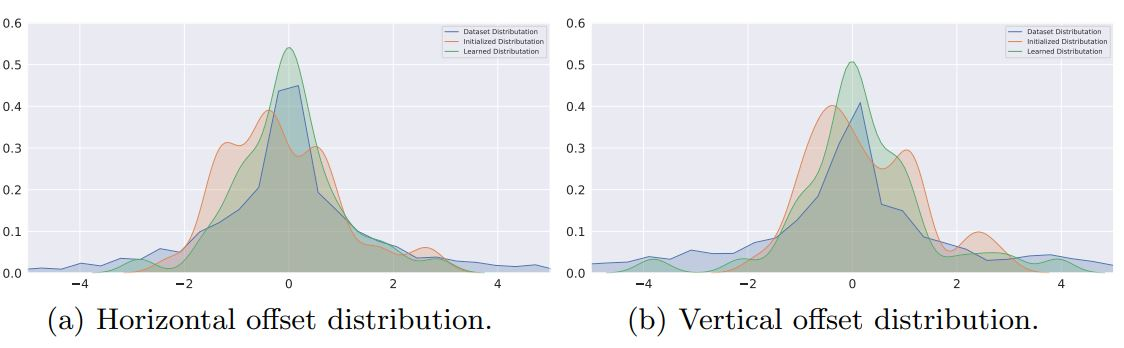

The first thing to note about the two distributions is that these look nothing like those found in the paper. There are many likely causes such as a lack of training data, different training data, different hyperparameters, a different feature extraction model and a slightly different method. Nevertheless, there are some conclusions that can be drawn from the distributions found. First of all, there are large peaks present in the obtained distributions. These peaks are caused by the fact that the features do not move that much between frames, and that there are not that many features present within frames (during training never more than two frames were observed). This means that whenever a $p_n$ is chosen, it is likely that this point doesn't change throughout the training. This is especially the case with the giant peaks observed in the found distributions. These points probably have remained constant throughout all 10 videos, over all epochs. The best way to smooth out this distribution is more training. This was however not possible due to long computation times. Furthermore, currently each frame is handled as a key-frame. Finally, possible differences can also be caused by the fact that there was an uncertainty in how to pick the initialisation parameters such as the initial sampling point and the fact that the learning rate was not optimised and kept constant which differs from the paper.

# Reproducibility

In order to reproduce the results of the paper two things were tried. First, it was attempted to run the code provided by the authors. The code was made for Linux systems, but also included a Windows variant. Due to not having a Linux system available, it was first tried to get the Windows version to run, but due to missing files and packages this did not work out. After that, it was attempted to implement the Linux version using Google Colab. However, the problem is that Colab only supports python 3 since November 2020 and the code itself was written in python 2. It was attempted to make the code compatible with python 3, but this ended up not working out. This means that it is very diffcult to say whether or not there is reproducibility in the code provided by the authors when using the exact same systems as they did. However, it can be said that it was very unclear initially what systems were required and that the alternative versions of the code that were also provided did not work when used follwing their instructions. Second, after failing to use the provided code, it was tried to recreate parts of the code from scratch. During this multiple problems occured due to certain details missing in the paper or things being unclear which made it necessary to make additional assumptions or simplifications. An example of this is when during the part on aggregation in the LSTS module the authors talk about getting c dimensional vectors, while following their steps only led to single values, making it unclear whether or not the steps taken were correct. Another problem occured in the sampling of the features where the authors were very unclear in how they took their original samples. These things might be obvious for people with more experience in the field of deep learning and computer science, but using just the knowledge gained from this course, it made it very difficult to get to similar results following the exact same method as the paper.

Everything considered, it is very difficult to say whether or not the problems in reproducibility lie within the paper, or within lack of the resources and knowledge required to reproduce the paper. However, there are certainly things that could be a lot clearer in both the paper itself and the instructions on how to get the provided code to run.